# Comparison of Linear Bayesian Regressors 

As an example of the interoperability of scikit-stan with scikit-learn, we will compare the performance of the following Bayesian regressors: automatic Relevance Determination (ARD), Bayesian Ridge Regression (BRR), and the Generalized (Bayesian) Linear Model (GLM) from scikit-stan. 

These examples are based on this scikit-learn example: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ard.html

In [1]:
from scikit_stan import GLM

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('axes.spines', top=True, bottom=True, left=True, right=True)
#mpl.rc('axes', facecolor='white')
mpl.rc("xtick", bottom=True, labelbottom=True)
mpl.rc("ytick", left=True, labelleft=True)
mpl.style.use('ggplot')


# center images
from IPython.core.display import HTML
HTML("""
<style>
.jp-RenderedImage, .output_png{
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

We create an artificial dataset where ``X`` and ``y`` are linearly linked but in such a way that only ``10`` features ``X`` are used to generate ``y``. Since there are ``100`` features, other features are irrelevant for establishing a relationship with ``y``. 

This problem is made even more difficult for a linear regression by generating a dataset where the number of samples is equal to the number of features as this may lead to unreasonably large weights. 

In [3]:
from sklearn.datasets import make_regression

X, y, true_weights = make_regression(
    n_samples=100,
    n_features=100,
    n_informative=10,
    noise=8,
    coef=True,
    random_state=42,
)

In [4]:
from sklearn.linear_model import ARDRegression, LinearRegression, BayesianRidge

olr = LinearRegression().fit(X, y)
brr = BayesianRidge(compute_score=True, n_iter=30).fit(X, y)
ard = ARDRegression(compute_score=True, n_iter=30).fit(X, y)
glm = GLM().fit(X, y)

/opt/hostedtoolcache/Python/3.9.13/x64/lib/python3.9/site-packages/scikit_stan/generalized_linear_regression/glm.py:376: UserWarning: 
                    Link function not specified. Using default link function 'identity'
                    for family 'gaussian'.
                
  warnings.warn(
/opt/hostedtoolcache/Python/3.9.13/x64/lib/python3.9/site-packages/scikit_stan/generalized_linear_regression/glm.py:476: UserWarning: Prior on intercept not specified. Using default prior.
                alpha ~ normal(mu(y), 2.5 * sd(y)) if Gaussian family else normal(0, 2.5)
  warnings.warn(
/opt/hostedtoolcache/Python/3.9.13/x64/lib/python3.9/site-packages/scikit_stan/generalized_linear_regression/glm.py:522: UserWarning: Prior on auxiliary parameter not specified. Using default unscaled prior
                        sigma ~ exponential(1)
                    
  warnings.warn(
15:07:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:07:20 - cmdstanpy - INFO - CmdStan done processing.


To assess the performance of the different regressors, we compare the coefficients of each of the model against the generative model.

/opt/hostedtoolcache/Python/3.9.13/x64/lib/python3.9/site-packages/traitlets/traitlets.py:3278: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  warn(


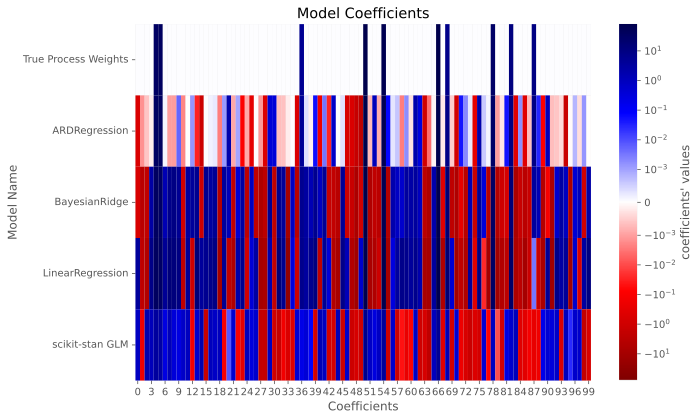

In [5]:
import seaborn as sns
from matplotlib.colors import SymLogNorm

df = pd.DataFrame(
    {
        "True Process Weights": true_weights,
        "ARDRegression": ard.coef_,
        "BayesianRidge": brr.coef_,
        "LinearRegression": olr.coef_,
        "scikit-stan GLM": glm.beta_
    }
)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    df.T,
    norm=SymLogNorm(linthresh=10e-4, vmin=-80, vmax=80),
    cbar_kws={"label": "coefficients' values"},
    cmap="seismic_r",
)
plt.ylabel("Model Name")
plt.xlabel("Coefficients")
plt.tight_layout(rect=(0, 0, 1, 0.95))
_ = plt.title("Model Coefficients")

The additive noise and the probabilistic setting ensures that that none of the models obtain the generative model's true weights. For a discussion of the first three models, please refer to the original ``scikit-learn`` example linked above. We observe, however, that unlike the Bayesian Ridge and OLS models, the regression coefficients of the ``scikit-stan`` GLM are not as skewed to the upper throes of the interval ``[-10, 10]`` and are instead, on average, closer to the midpoint of the interval. That being said, the ARD model produces a sparser solution as it retains some non-informative coefficients of the true generative process.  

## Regression with Polynomial Feature Expansion

We now provide an example with a target that is a non-linear function of the input feature, and as usual, has noise that follows a standard uniform distribution. This example also shows a non-trivial ``Pipeline`` of ``scikit-learn`` models into which the ``scikit-stan`` model is embedded seamlessly, while also illustrating an important shortcoming of polynomial extrapolation. 

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

rng = np.random.RandomState(0)
n_samples = 110

# sort the data to make plotting easier later
X = np.sort(-10 * rng.rand(n_samples) + 10)
noise = rng.normal(0, 1, n_samples) * 1.35
y = np.sqrt(X) * np.sin(X) + noise
full_data = pd.DataFrame({"Input Feature": X, "Target": y})
X = X.reshape((-1, 1))

# extrapolation
X_plot = np.linspace(10, 10.4, 10)
y_plot = np.sqrt(X_plot) * np.sin(X_plot)
X_plot = np.concatenate((X, X_plot.reshape((-1, 1))))
y_plot = np.concatenate((y - noise, y_plot))

The regressors are fit under a 10th degree polynomial as an attempt to induce overfitting. Note that thte Bayesian models regularize the size of the polynomial's coefficients. 

We also demonstrate the similarity in the API for the ``predict()`` method of ``scikit-stan`` models as the ``return_std=True`` option returns the standard deviation of the posterior distribution for model parameters analogously to ``scikit-learn`` models.

In [7]:
ard_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    ARDRegression(),
).fit(X, y)
y_ard, y_ard_std = ard_poly.predict(X_plot, return_std=True)

glm_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    GLM()
).fit(X, y)

y_glm, y_glm_std = glm_poly.predict(X_plot, return_std=True)

/opt/hostedtoolcache/Python/3.9.13/x64/lib/python3.9/site-packages/scikit_stan/generalized_linear_regression/glm.py:376: UserWarning: 
                    Link function not specified. Using default link function 'identity'
                    for family 'gaussian'.
                
  warnings.warn(
/opt/hostedtoolcache/Python/3.9.13/x64/lib/python3.9/site-packages/scikit_stan/generalized_linear_regression/glm.py:476: UserWarning: Prior on intercept not specified. Using default prior.
                alpha ~ normal(mu(y), 2.5 * sd(y)) if Gaussian family else normal(0, 2.5)
  warnings.warn(
/opt/hostedtoolcache/Python/3.9.13/x64/lib/python3.9/site-packages/scikit_stan/generalized_linear_regression/glm.py:522: UserWarning: Prior on auxiliary parameter not specified. Using default unscaled prior
                        sigma ~ exponential(1)
                    
  warnings.warn(
15:07:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:07:26 - cmdstanpy - INFO - CmdStan done processing.


15:07:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/runner/work/scikit-stan/scikit-stan/scikit_stan/stan_files/glm_v_continuous.stan', line 72, column 4 to column 35)
Consider re-running with show_console=True if the above output is unclear!


15:07:26 - cmdstanpy - INFO - Chain [1] start processing


15:07:26 - cmdstanpy - INFO - Chain [1] done processing


15:07:26 - cmdstanpy - INFO - Chain [2] start processing


15:07:26 - cmdstanpy - INFO - Chain [2] done processing


15:07:26 - cmdstanpy - INFO - Chain [3] start processing


15:07:26 - cmdstanpy - INFO - Chain [3] done processing


15:07:26 - cmdstanpy - INFO - Chain [4] start processing


15:07:27 - cmdstanpy - INFO - Chain [4] done processing


We now visually show the failure of extrapolation of these models due to the inherent restrictions of polynomial regressions. The error bars represent one standard deviation of hte predicted Gaussian distribution of sample points.  

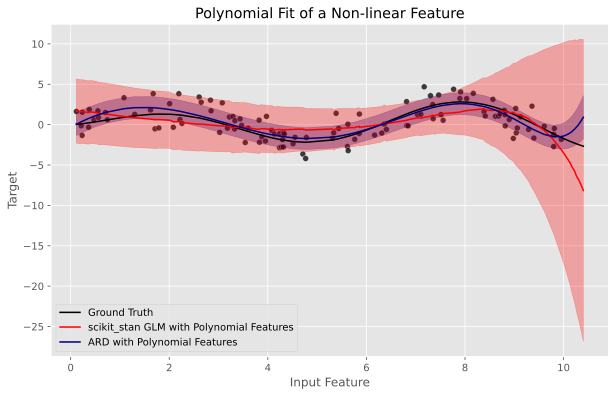

In [8]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=full_data, x="Input Feature", y="Target", color="black", alpha=0.75
)
ax.plot(X_plot, y_plot, color="black", label="Ground Truth")
ax.plot(X_plot, y_glm, color="red", label="scikit_stan GLM with Polynomial Features")
ax.plot(X_plot, y_ard, color="navy", label="ARD with Polynomial Features")
ax.fill_between(
    X_plot.ravel(),
    y_ard - y_ard_std,
    y_ard + y_ard_std,
    color="navy",
    alpha=0.3,
)
ax.fill_between(
    X_plot.ravel(),
    y_glm - y_glm_std,
    y_glm + y_glm_std,
    color="red",
    alpha=0.3,
)
ax.legend(loc="lower left")
_ = ax.set_title("Polynomial Fit of a Non-linear Feature")